In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sources : https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66

In [58]:
data = pd.read_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_clean.csv')
data = data
print(data.shape)

(100000, 57)


La taille de nos données (100 000) combinée à la longueur des mails est trop importante pour appliquer nos aglorithmes de ML. On doit donc faire une selection des mots, cependant même après un pre-process (enlever les ponctuations, les stops words, les mots inintéressants), la longueur de tous les mots et toujours trop grande (+ de 20 000). On va donc selectionner les plus importants, après une réduction de dimension (ACP), on appliquera un algorithme de clustering. Cela nous permettra de connaître les mots les plus importants pour chaque cluster. On va prendre ceux là.

<br>
pre-processing

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:

def punctuation_stop(text):
    """remove punctuation and stop words"""
    word_uninterested = ['subject', 'content', 'image', 'ect', 'the']
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if (w not in stop_words) and w.isalpha() and (w.lower() not in word_uninterested) and (len(w)>2):
            filtered.append(w.lower())
    text = " ".join([ele for ele in filtered])
    return text






 - Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [6]:
vectorizer = TfidfVectorizer(preprocessor=punctuation_stop,max_df=0.50,min_df=2,
                             )
X = vectorizer.fit_transform(data['content'])

- vizualisation with PCA to understanding content.

In [7]:
from sklearn.decomposition import PCA

In [8]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)


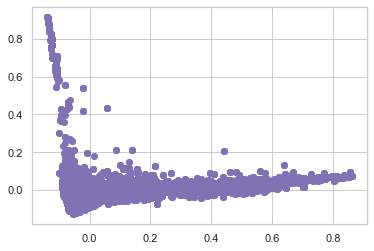

In [9]:
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

- Top topics

In [10]:
features = vectorizer.get_feature_names()


- Clustering

In [11]:
from sklearn.cluster import KMeans

In [12]:
k = 3
kmeans = KMeans(n_clusters= k, init='k-means++',n_init=100, random_state=111)
y_pred = kmeans.fit_predict(X)
kmeans.cluster_centers_


array([[1.00608046e-04, 6.66345194e-07, 2.24329243e-06, ...,
        5.08858072e-05, 2.55005295e-07, 1.73170894e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

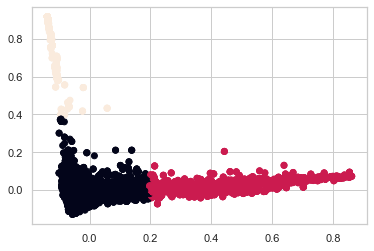

In [18]:
plt.scatter(coords[:, 0], coords[:, 1], c=kmeans.labels_)

In [19]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_mean_feats(X, features,grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [43]:
features = vectorizer.get_feature_names()
dfs = top_feats_per_cluster(X,y_pred,features)


In [44]:
print(dfs[0])
print('-'*30)
print(dfs[1])
print('-'*30)
print(dfs[2])

    features     score
0      enron  0.014947
1       john  0.012089
2        ect  0.011634
3      sally  0.011324
4       bass  0.010322
5       eric  0.010274
6    phillip  0.009687
7     please  0.008443
8     thanks  0.008376
9    meeting  0.008044
10  attached  0.007378
11   message  0.006911
12      know  0.006676
13     would  0.006555
14      week  0.006488
15       gas  0.006376
16      game  0.006029
17       let  0.005803
18      call  0.005733
19     power  0.005697
20    report  0.005583
21       get  0.005417
22   trading  0.005349
23       new  0.005273
24      sent  0.005083
------------------------------
          features     score
0              ect  0.422076
1            enron  0.139279
2   communications  0.059415
3              ees  0.043336
4             eric  0.041511
5            bryan  0.029096
6            brian  0.025223
7          matthew  0.021265
8       enronxgate  0.019199
9          phillip  0.019029
10         meeting  0.018846
11            game  0.0

<AxesSubplot:>

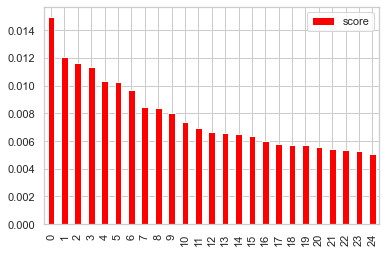

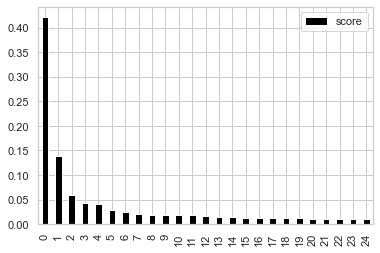

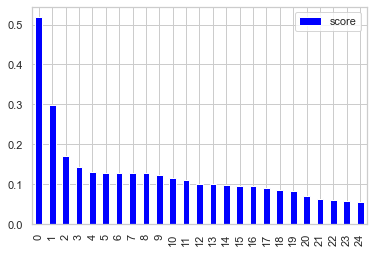

In [45]:
dfs[0].plot.bar(color='red')
dfs[1].plot.bar(color='black')
dfs[2].plot.bar(color='blue')

<br>
On va garder seulement, les 25 meilleurs mots de chaque clusters.

In [56]:
df_features = pd.concat([dfs[0]['features'], dfs[1]['features'],dfs[2]['features']])
features = df_features.to_numpy()
features

array(['enron', 'john', 'ect', 'sally', 'bass', 'eric', 'phillip',
       'please', 'thanks', 'meeting', 'attached', 'message', 'know',
       'would', 'week', 'gas', 'game', 'let', 'call', 'power', 'report',
       'get', 'trading', 'new', 'sent', 'ect', 'enron', 'communications',
       'ees', 'eric', 'bryan', 'brian', 'matthew', 'enronxgate',
       'phillip', 'meeting', 'game', 'timothy', 'david', 'john', 'sally',
       'luis', 'forwarded', 'hector', 'michael', 'brenda', 'hull', 'chad',
       'tim', 'shanna', 'request', 'resource', 'approval', 'act', 'upon',
       'applications', 'requested', 'type', 'name', 'create', 'click',
       'approver', 'review', 'backoffice', 'for', 'eol', 'date',
       'security', 'listed', 'manager', 'received', 'email', 'you',
       'data', 'pending'], dtype=object)

In [62]:
def best_features_selection(text):
    features = ['enron', 'john', 'ect', 'sally', 'bass', 'eric', 'phillip',
       'please', 'thanks', 'meeting', 'attached', 'message', 'know',
       'would', 'week', 'gas', 'game', 'let', 'call', 'power', 'report',
       'get', 'trading', 'new', 'sent', 'ect', 'enron', 'communications',
       'ees', 'eric', 'bryan', 'brian', 'matthew', 'enronxgate',
       'phillip', 'meeting', 'game', 'timothy', 'david', 'john', 'sally',
       'luis', 'forwarded', 'hector', 'michael', 'brenda', 'hull', 'chad',
       'tim', 'shanna', 'request', 'resource', 'approval', 'act', 'upon',
       'applications', 'requested', 'type', 'name', 'create', 'click',
       'approver', 'review', 'backoffice', 'for', 'eol', 'date',
       'security', 'listed', 'manager', 'received', 'email', 'you',
       'data', 'pending']
    
    filtered = []
    word_tokens = word_tokenize(text)
    
    for w in word_tokens:
        if w.lower() in features:
            filtered.append(w.lower())
            
    text = " ".join([ele for ele in filtered])
    
    return text
    
    

<br>
<b> Vectorization</b>

In [63]:
vectorizer = TfidfVectorizer(preprocessor=best_features_selection,max_df=0.50,min_df=2,
                             )
X = vectorizer.fit_transform(data['content'])

In [68]:
print(X)

  (1, 28)	0.3207474197714623
  (1, 64)	0.8673010979658633
  (1, 38)	0.3806703274188278
  (3, 44)	1.0
  (4, 33)	1.0
  (5, 44)	1.0
  (6, 31)	0.3254563631472363
  (6, 45)	0.20058173104122837
  (6, 44)	0.9240374044699048
  (9, 36)	0.10925879511259404
  (9, 10)	0.06953254224069766
  (9, 60)	0.09766422653461698
  (9, 46)	0.2478047299348087
  (9, 27)	0.9214911631987559
  (9, 25)	0.06995039912613889
  (9, 33)	0.06954064583932787
  (9, 44)	0.2311002646523114
  (10, 19)	0.4177001238570293
  (10, 49)	0.4131039700878131
  (10, 21)	0.4688057913696751
  (10, 27)	0.34765638434641705
  (10, 25)	0.29029657794331587
  (10, 44)	0.4795370493124999
  (11, 12)	0.9744644864228703
  (11, 44)	0.224541676979156
  :	:
  (99995, 25)	0.2263294504386341
  (99995, 45)	0.24346940666457673
  (99995, 33)	0.11250183238826879
  (99995, 64)	0.09647008053137567
  (99996, 57)	0.26390427499529096
  (99996, 18)	0.9645488757129986
  (99997, 8)	0.5619866266681289
  (99997, 47)	0.4407125482802027
  (99997, 57)	0.3014524680037748

In [69]:
df_vect = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

In [85]:
data.columns

Index(['DayWeek', 'Cat_1_level_1', 'Cat_1_level_2', 'Cat_1_weight',
       'Cat_2_level_1', 'Cat_2_level_2', 'Cat_2_weight', 'Cat_3_level_1',
       'Cat_3_level_2', 'Cat_3_weight', 'Cat_4_level_1', 'Cat_4_level_2',
       'Cat_4_weight', 'Cat_5_level_1', 'Cat_5_level_2', 'Cat_5_weight',
       'Cat_6_level_1', 'Cat_6_level_2', 'Cat_6_weight', 'Cat_7_level_1',
       'Cat_7_level_2', 'Cat_7_weight', 'Cat_8_level_1', 'Cat_8_level_2',
       'Cat_8_weight', 'Cat_9_level_1', 'Cat_9_level_2', 'Cat_9_weight',
       'Cat_10_level_1', 'Cat_10_level_2', 'Years', 'Month', 'Day', 'Hours',
       'content_char_len', 'content_char_length_category', 'content_word_len',
       'content_word_length_category', 'To_count'],
      dtype='object')

In [75]:
data = data[['DayWeek','Cat_1_level_1',
       'Cat_1_level_2', 'Cat_1_weight', 'Cat_2_level_1', 'Cat_2_level_2',
       'Cat_2_weight', 'Cat_3_level_1', 'Cat_3_level_2', 'Cat_3_weight',
       'Cat_4_level_1', 'Cat_4_level_2', 'Cat_4_weight', 'Cat_5_level_1',
       'Cat_5_level_2', 'Cat_5_weight', 'Cat_6_level_1', 'Cat_6_level_2',
       'Cat_6_weight', 'Cat_7_level_1', 'Cat_7_level_2', 'Cat_7_weight',
       'Cat_8_level_1', 'Cat_8_level_2', 'Cat_8_weight', 'Cat_9_level_1',
       'Cat_9_level_2', 'Cat_9_weight', 'Cat_10_level_1', 'Cat_10_level_2','Years', 'Month', 'Day', 'Hours',
       'content_char_len', 'content_char_length_category', 'content_word_len',
       'content_word_length_category', 'To_count']]

In [76]:
new_df  = pd.concat([data, df_vect], axis=1)

In [77]:
new_df.head()

,DayWeek,Cat_1_level_1,Cat_1_level_2,Cat_1_weight,Cat_2_level_1,Cat_2_level_2,Cat_2_weight,Cat_3_level_1,Cat_3_level_2,Cat_3_weight,...,sent,shanna,thanks,tim,timothy,trading,type,upon,week,would
0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.867301
2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [84]:
new_df.to_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_pre_process.csv')

<br>
Clustering 2 : DBSCAN

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [19]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
y_pred = dbscan.fit_predict(X)

In [20]:
print(np.unique(dbscan.labels_)) #-1 for anomalies
print('-'*100)
print(len(dbscan.core_sample_indices_))

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))



[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118]
----------------------------------------------------------------------------------------------------
985
Estimated number of clusters: 119
Estimated number of noise points: 9015
Silhouette Coefficient: -0.168


Text(0.5, 1.0, 'DBSCAN')

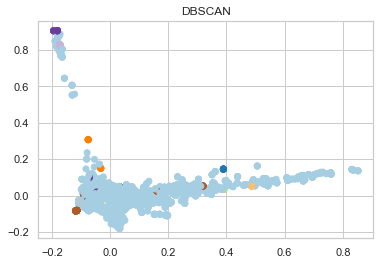

In [23]:
X_array = X.toarray()
plt.scatter( X_array[:,0], X_array[:,1],c=dbscan.labels_, cmap='Paired')
plt.title("DBSCAN")

<br>
clustering 3 - GaussianMixture